# Music Categorization and Playlist Creation using Machine Learning

## 1. Setup and Imports

In [1]:
import os
import numpy as np
from tqdm import tqdm  # Import the tqdm library for progress bars
import librosa
import essentia.standard as es
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
from urllib.parse import unquote
import json  # For caching
import hashlib  # To create unique identifiers for songs
from collections import Counter
from sklearn.utils import resample
import hashlib
import random
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import keras_tuner as kt

In [2]:
from utilities import generate_hash, extract_features, separate_and_process_features, parse_and_extract_xml

In [3]:
# Function to save the cache after processing each song
def save_cache(features_cache):
    with open(cache_file_path, 'w') as cache_file:
        json.dump(features_cache, cache_file)

# Audio Feature Extraction Overview

The `extract_features` function is designed to extract various audio features from a song by analyzing multiple segments of the audio file. This process helps capture the overall characteristics of the song, which is particularly useful for genres like electronic music where different sections may have distinct properties.

## Extracted Features

### 1. **MFCCs (Mel-Frequency Cepstral Coefficients)**
   - **Description**: MFCCs are coefficients that represent the short-term power spectrum of sound, commonly used in speech and audio processing. They are derived from a type of cepstral representation of the audio clip.
   - **Usage**: Often used in music genre classification, speech recognition, and sound identification.

### 2. **Chroma Features**
   - **Description**: Chroma features relate to the twelve different pitch classes (such as C, C#, D, etc.) in music. They are a powerful representation of the harmonic content of a song.
   - **Usage**: Useful for tasks involving harmony, chord recognition, and key detection.

### 3. **Spectral Contrast**
   - **Description**: Spectral contrast measures the difference in amplitude between peaks and valleys in a sound spectrum. It captures the harmonic structure and timbral texture of a sound.
   - **Usage**: Helps in distinguishing between different music genres and identifying musical instruments.

### 4. **Zero-Crossing Rate (ZCR)**
   - **Description**: ZCR is the rate at which the signal changes sign (i.e., from positive to negative or vice versa). It is a measure of the noisiness of the signal.
   - **Usage**: Commonly used in audio classification, particularly for detecting percussive sounds and distinguishing between voiced and unvoiced speech.

### 5. **Spectral Centroid**
   - **Description**: The spectral centroid is the "center of mass" of the spectrum, which indicates where the center of energy is located in the frequency domain.
   - **Usage**: Often associated with the brightness of a sound; higher values correspond to brighter, more treble-rich sounds.

### 6. **RMS (Root Mean Square Energy)**
   - **Description**: RMS measures the average power or loudness of the audio signal. It is a straightforward measure of the energy present in the signal.
   - **Usage**: Used in audio analysis for volume normalization and dynamic range compression.

### 7. **Harmonic/Percussive Components**
   - **Description**: This feature separates the harmonic (tonal) and percussive (transient) elements of the audio signal.
   - **Usage**: Useful for rhythm analysis, music separation, and remixing tasks.

### 8. **Spectral Roll-off**
   - **Description**: Spectral roll-off is the frequency below which a certain percentage (e.g., 85%) of the total spectral energy is contained. It indicates the amount of high-frequency content in the signal.
   - **Usage**: Helps in identifying whether a sound is dominated by high or low frequencies, which can be useful in genre classification.

### 9. **Tonnetz (Tonal Centroid Features)**
   - **Description**: Tonnetz features represent the harmonic relationships in music, such as intervals and chords. These are calculated using a tonnetz diagram which maps harmonic relationships.
   - **Usage**: Primarily used in music information retrieval, key detection, and chord recognition.

## Summary
These features, when combined, provide a comprehensive representation of the audio signal, capturing various aspects such as timbre, harmony, rhythm, and loudness. By sampling multiple segments of the song, the `extract_features` function ensures that the extracted features are representative of the entire track, making it a robust tool for music analysis tasks.

## Loading and Processing Data

In [4]:
# Path to cache file
cache_file_path = "./data/features_cache_1.json"
# Load the cache if it exists

if os.path.exists(cache_file_path):
    with open(cache_file_path, 'r') as cache_file:
        features_cache = json.load(cache_file)
else:
    features_cache = {}

In [5]:
# Function to load data and labels from XML and TXT files
def load_data_from_files(category_files):
    X = []
    y = []
    for label, file_path in category_files.items():
        if file_path.endswith('.xml'):
            song_paths, _ = parse_and_extract_xml(file_path)
        else:
            with open(file_path, 'r', encoding='latin-1') as f:
                song_paths = [line.strip() for line in f]
        
        print(f"Processing {len(song_paths)} songs from {file_path} under label '{label}'")
        
        for song_path in tqdm(song_paths, desc=f"Processing {label} songs", unit="song"):
            if os.path.exists(song_path):
                file_hash = generate_hash(song_path)
                features = extract_features(features_cache, song_path)
                if features is not None:
                    X.append({file_hash: features})  # Store dictionary with file_hash as key
                    y.append({file_hash: label})  # Store dictionary with file_hash as key
            else:
                print(f"File not found: {song_path}")
                
    return X, y  # Returning lists of dictionaries


In [6]:
def balance_data(X, y):
    # First, let's segregate the samples based on their labels
    label_to_samples = {}
    
    for i, label_dict in enumerate(y):
        sample_key = list(label_dict.keys())[0]
        label = label_dict[sample_key]
        if label not in label_to_samples:
            label_to_samples[label] = []
        label_to_samples[label].append((X[i], y[i]))
    
    # Identify the minimum and maximum number of samples across classes
    min_samples = min(len(samples) for samples in label_to_samples.values())
    max_samples = max(len(samples) for samples in label_to_samples.values())
    
    # Calculate the target number of samples (halfway between min and max)
    target_samples = (min_samples + max_samples) // 2
    
    # Initialize lists for the balanced data
    balanced_X = []
    balanced_y = []
    
    for label, samples in label_to_samples.items():
        num_samples = len(samples)
        
        if num_samples > target_samples:
            # Downsample if the class has more samples than the target
            downsampled_samples = random.sample(samples, target_samples)
            balanced_X.extend([sample_X for sample_X, _ in downsampled_samples])
            balanced_y.extend([sample_y for _, sample_y in downsampled_samples])
        
        elif num_samples < target_samples:
            # Upsample if the class has fewer samples than the target
            upsampled_samples = random.choices(samples, k=target_samples)
            balanced_X.extend([sample_X for sample_X, _ in upsampled_samples])
            balanced_y.extend([sample_y for _, sample_y in upsampled_samples])
        
        else:
            # If the class is already at the target, just add the samples
            balanced_X.extend([sample_X for sample_X, _ in samples])
            balanced_y.extend([sample_y for _, sample_y in samples])
    
    return balanced_X, balanced_y


In [50]:
def flatten_data(X, y):
    """Flatten the lists of dictionaries into a single DataFrame and a Series."""
    features_list = []
    labels_list = []
    
    for feature_dict, label_dict in zip(X, y):
        file_hash = list(feature_dict.keys())[0]  # Extract file hash
        features = feature_dict[file_hash]  # Extract the features tuple
        label = label_dict[file_hash]  # Extract the label
        
        # Create a single row with file_hash as an identifier
        row = {'file_hash': file_hash, **features}
        features_list.append(row)
        labels_list.append(label)
    
    features_df = pd.DataFrame(features_list)
    labels_series = pd.Series(labels_list, name='label')
    
    return features_df, labels_series

def remove_outliers(df, method='zscore', threshold=3, iqr_multiplier=1.5, retain_percentile=90, time_series_columns=[]):
    """
    Remove or retain outliers from a DataFrame using the specified method.
    
    Args:
        df (DataFrame): The DataFrame from which to remove outliers.
        method (str): The method to use for outlier detection ('zscore', 'iqr', or 'none').
        threshold (float): The threshold for identifying outliers (used for 'zscore' method).
        iqr_multiplier (float): The multiplier for the IQR range (used for 'iqr' method).
        retain_percentile (float): The percentage of data points closest to the mean to retain (0-100).
        time_series_columns (list): List of columns that contain time series data.
    
    Returns:
        DataFrame: The DataFrame with outliers removed or adjusted.
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    for column in numeric_columns:
        if column in time_series_columns:
            # Assuming time series data is stored in lists or arrays within the DataFrame cells
            # You could compute various summary statistics:
            print('column:', column)
            df[column + '_mean'] = df[column].apply(np.mean)
            df[column + '_std'] = df[column].apply(np.std)
            df[column + '_min'] = df[column].apply(np.min)
            df[column + '_max'] = df[column].apply(np.max)
            summary_stats = [column + '_mean', column + '_std', column + '_min', column + '_max']
            
            # Apply outlier detection on these summary statistics
            for stat in summary_stats:
                if method == 'zscore':
                    z_scores = np.abs(stats.zscore(df[stat]))
                    df = df[z_scores < threshold]
                elif method == 'iqr':
                    Q1 = df[stat].quantile(0.25)
                    Q3 = df[stat].quantile(0.75)
                    IQR = Q3 - Q1
                    df = df[~((df[stat] < (Q1 - iqr_multiplier * IQR)) | (df[stat] > (Q3 + iqr_multiplier * IQR)))]
                
        else:
            # Non-time series data can be processed as before
            if method == 'zscore':
                z_scores = np.abs(stats.zscore(df[column]))
                df = df[z_scores < threshold]
            elif method == 'iqr':
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                df = df[~((df[column] < (Q1 - iqr_multiplier * IQR)) | (df[column] > (Q3 + iqr_multiplier * IQR)))]

    if retain_percentile < 100:
        # Compute the distance from the mean for each numeric column separately
        distance_from_mean = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(x - x.mean()))
        
        # Apply percentile cutoff based on feature-level distance
        for column in numeric_columns:
            overall_distance = distance_from_mean[column]
            cutoff = np.percentile(overall_distance, retain_percentile)
            df = df[overall_distance <= cutoff]

    return df



def reconstruct_data(features_df, labels_series):
    """Reconstruct the original dictionary structure after outlier removal."""
    X_cleaned = []
    y_cleaned = []
    
    for index, row in features_df.iterrows():
        file_hash = row['file_hash']
        features = row.drop('file_hash').to_dict()
        label = labels_series.iloc[index]
        
        X_cleaned.append({file_hash: features})
        y_cleaned.append({file_hash: label})
    
    return X_cleaned, y_cleaned

In [30]:
# Paths to your files
category_files = {
    "liked": "./data/liked.xml",
    "disliked": "./data/disliked.xml",
}

# Load the data for liked and disliked categories
category_files_for_training = {
    "liked": category_files["liked"],
    "disliked": category_files["disliked"]
}

X, y = load_data_from_files(category_files_for_training)

Processing 623 songs from ./data/liked.xml under label 'liked'


Processing liked songs:   0%|                       | 0/623 [00:00<?, ?song/s]/Users/beenerdy/code/AI&ML/venv/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing liked songs: 100%|█████████████| 623/623 [00:06<00:00, 96.84song/s]


Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Disco Connection (Original Mix)-Qubiko.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
Processing 1173 songs from ./data/disliked.xml under label 'disliked'


Processing disliked songs:   0%|                   | 0/1173 [00:00<?, ?song/s]

File not found: /Users/octavianrotari/.Trash/A Moment Of Silence (Original Mix)-Celestial Strangers.mp3
File not found: /Users/octavianrotari/.Trash/Bagan (Nebula AR Remix)-Urmet K.mp3
File not found: /Users/octavianrotari/.Trash/Purple Noise (Boris Brejcha Re-Noise Edit 2021)-Boris Brejcha.aiff
File not found: /Users/octavianrotari/.Trash/Dopamine Machine (Club Mix)-CamelPhat, Ali Love.aiff
File not found: /Users/octavianrotari/.Trash/Can You Feel It (Steve Bug Re-Dub)-Chez Damier.mp3
File not found: /Users/octavianrotari/Music/Lexicon/Uploaded/Wunderbar (Original Mix)-Dan Caster.mp3
File not found: /Users/octavianrotari/.Trash/Africa (Original Mix)-Digitaline.mp3
File not found: /Users/octavianrotari/.Trash/Fruit&Sun-ford..m4a


Processing disliked songs:  58%|████▋   | 684/1173 [00:06<00:04, 106.80song/s]

Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Your Love-Frankie Knuckles.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
File not found: /Users/octavianrotari/.Trash/Want You All _ Love On The Line (Accapella) - Mixed-Jade Cox.mp3
File not found: /Users/octavianrotari/.Trash/Dear Life Feat. Jaw (Original Mix)-Jaw, Claptone.mp3
Audio too short: /Users/beenerdy/Music/Lexicon/Uploaded/Mit Dir-Jurgen Paape.mp3


Note: Illegal Audio-MPEG-Header 0xb5ed85ec at offset 155632.
Note: Trying to resync...
Note: Skipped 176 bytes in input.
Note: Illegal Audio-MPEG-Header 0xe0e5e60c at offset 321947.
Note: Trying to resync...
Note: Skipped 130 bytes in input.
Processing disliked songs: 100%|████████| 1173/1173 [00:13<00:00, 89.59song/s]

Error encountered while parsing file: /Users/beenerdy/Music/Lexicon/Uploaded/Almost Home-Moby.mp3 - error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.
File not found: /Users/octavianrotari/.Trash/Who Loves The Sun (Original Mix)-Nu, Joke.mp3
File not found: /Users/octavianrotari/.Trash/Annie Hall-Oskar Linnros.mp3
File not found: /Users/octavianrotari/.Trash/Citrus Grove-Sans Souci.m4a
File not found: /Users/octavianrotari/.Trash/Juni-Snook.mp3
[{'65bd335f1e73d43a02d3d7aef124746c': {'mfccs_mean': [-271.26263427734375, 133.83587646484375, 9.941889762878418, 29.74044418334961, 3.2974579334259033, 18.59088897705078, 0.7992393970489502, 6.240644454956055, -1.057356595993042, 1.0667896270751953, -0.42551106214523315, 2.614684820175171, -4.780033588409424], 'chroma_mean': [0.32548215985298157, 0.38300222158432007, 0.5309675931930542, 0.771767258644104, 0.5538772344589233, 0.4414

In [31]:
print(X[:1])

[{'65bd335f1e73d43a02d3d7aef124746c': {'mfccs_mean': [-271.26263427734375, 133.83587646484375, 9.941889762878418, 29.74044418334961, 3.2974579334259033, 18.59088897705078, 0.7992393970489502, 6.240644454956055, -1.057356595993042, 1.0667896270751953, -0.42551106214523315, 2.614684820175171, -4.780033588409424], 'chroma_mean': [0.32548215985298157, 0.38300222158432007, 0.5309675931930542, 0.771767258644104, 0.5538772344589233, 0.4414367079734802, 0.4594242572784424, 0.4281294345855713, 0.4414038062095642, 0.41678673028945923, 0.475236713886261, 0.36393773555755615], 'spectral_contrast_mean': [16.226758606896507, 12.614221472299233, 16.63107071722955, 17.988046600491153, 19.616288322323864, 18.673123606890645, 50.910557482470544], 'zcr_mean': 0.03469048278418177, 'spectral_centroid_mean': 2080.135179018758, 'rms_mean': 0.13981807231903076, 'harmonic_mean': 3.0077882911427878e-05, 'percussive_mean': -2.8311374990153126e-05, 'spectral_rolloff_mean': 4283.146904984009, 'tonnetz_mean': [-0.2

In [58]:
# Initialize empty lists for liked and disliked features
liked_features = []
disliked_features = []

# Flatten the data
features_df, labels_series = flatten_data(X, y)
print(len(X))

# Step 1: Separate the data into liked and disliked categories
liked_features_df = features_df[labels_series == 'liked'].copy()
disliked_features_df = features_df[labels_series == 'disliked'].copy()


# Step 2: Remove outliers
cleaned_liked_features_df = remove_outliers(liked_features_df, method='zscore', threshold=3)
cleaned_disliked_features_df = remove_outliers(disliked_features_df, method='zscore', threshold=3)

# Step 3: Combine the liked and disliked data back together
cleaned_features_df = pd.concat([cleaned_liked_features_df, cleaned_disliked_features_df])

# Ensure the order of labels matches the cleaned features
cleaned_labels_series = labels_series[cleaned_features_df.index]

# Reset the index to align indices of features and labels
cleaned_features_df.reset_index(drop=True, inplace=True)
cleaned_labels_series = labels_series[cleaned_features_df.index].reset_index(drop=True)

# Step 4: Reconstruct the data
X_cleaned, y_cleaned = reconstruct_data(cleaned_features_df, cleaned_labels_series)
print(len(X_cleaned))

1778
622
277
506
783


/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/3484687826.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/3484687826.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/3484687826.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/3484687826.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/3484687826.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[overall_distance <= cutoff]
/var/folders/zs

In [60]:
X_balanced, y_balanced = balance_data(X_cleaned, y_cleaned)


# Extract just the labels from y_balanced for counting
labels_only = [list(item.values())[0] for item in y_balanced]

print(f"X balanced num of items: {len(X_balanced)}")
# Count the occurrences of each label
balanced_class_counts = Counter(labels_only)
print(f"Class distribution after balancing: {balanced_class_counts}")

X balanced num of items: 782
Class distribution after balancing: Counter({'liked': 391, 'disliked': 391})


## Step 1: Extract and Process Time-Series and Static Features Separately

In [61]:
#1. Feature Normalization/Standardization Functions

In [62]:
print(X_balanced[:1])

[{'b7cc4df9e5370a0ad3433a207e07a01c': {'mfccs_mean': [-208.46240234375, 121.60755157470703, -25.14738655090332, 19.960956573486328, -18.249523162841797, 24.95583724975586, -8.791031837463379, -0.2196430265903473, -6.600444793701172, 5.379800796508789, -10.24072551727295, 2.0452475547790527, -5.054422378540039], 'chroma_mean': [0.6135055422782898, 0.5441776514053345, 0.5731166005134583, 0.4745597839355469, 0.44653210043907166, 0.4484056830406189, 0.4280969798564911, 0.40411001443862915, 0.48869752883911133, 0.5694124698638916, 0.4952075481414795, 0.4871879518032074], 'spectral_contrast_mean': [19.12470729892888, 12.36567293367975, 15.148346099494802, 16.939703168516697, 17.517724576082557, 17.416865298047288, 33.52466607234998], 'zcr_mean': 0.08024185366638857, 'spectral_centroid_mean': 3310.2145037861287, 'rms_mean': 0.13733048737049103, 'harmonic_mean': 0.00011715623259078711, 'percussive_mean': -0.0001232309587066993, 'spectral_rolloff_mean': 6704.1340886059015, 'tonnetz_mean': [0.03

In [63]:
# Extract features and categorize them without modifying the original dictionary
def separate_features(entry):
    # Access the key and the corresponding feature dictionary
    hash_key = list(entry.keys())[0]
    features = entry[hash_key]  # Access the first element of the tuple which is the features dictionary
    
    # Time-series features (concatenated into one array)
    time_series_features = np.concatenate([
        features['mfccs_mean'],
        features['chroma_mean'],
        features['spectral_contrast_mean'],
        features['tonnetz_mean']
    ])
    
    # Static features
    static_features = [
        features['zcr_mean'],
        features['spectral_centroid_mean'],
        features['rms_mean'],
        features['harmonic_mean'],
        features['percussive_mean'],
        features['spectral_rolloff_mean'],
        features['spectral_bandwidth_mean'],
        features['spectral_flatness_mean'],
        features['tempo_mean'],
        features['onset_strength_mean']
    ]
    
    return time_series_features, static_features



# Apply the extraction to the entire list
X_time_series = []
X_static = []

for item in X_balanced:
    ts_features, static_features = separate_features(item)
    X_time_series.append(ts_features)
    X_static.append(static_features)

# Convert y_balanced into categorical values (1 for 'liked', 0 for 'disliked')
y_balanced_numeric = [1 if list(item.values())[0] == 'liked' else 0 for item in y_balanced]

# Create DataFrames
X_time_series_df = pd.DataFrame(X_time_series)
X_static_df = pd.DataFrame(X_static, columns=[
    'zcr_mean', 'spectral_centroid_mean', 'rms_mean', 
    'harmonic_mean', 'percussive_mean', 'spectral_rolloff_mean',
    'spectral_bandwidth_mean', 'spectral_flatness_mean',
    'tempo_mean', 'onset_strength_mean'
])

# Combine static features with labels
X_static_df['liked'] = y_balanced_numeric

# Optional: Standardize or normalize the time-series data
scaler = StandardScaler()
X_time_series_df_scaled = pd.DataFrame(scaler.fit_transform(X_time_series_df))

# Check the structure of the data
print("Static DataFrame:\n", X_static_df.head())
print("Time-Series DataFrame (scaled):\n", X_time_series_df_scaled.head())

# Assigning column names based on the presumed structure
mfcc_cols = [f'mfccs_mean_{i}' for i in range(13)]
chroma_cols = [f'chroma_mean_{i}' for i in range(12)]
spectral_contrast_cols = [f'spectral_contrast_mean_{i}' for i in range(7)]
tonnetz_cols = [f'tonnetz_mean_{i}' for i in range(6)]

# Combine all columns into a single list
column_names = mfcc_cols + chroma_cols + spectral_contrast_cols + tonnetz_cols

# Assign these column names to the DataFrame
X_time_series_df_scaled.columns = column_names


Static DataFrame:
    zcr_mean  spectral_centroid_mean  rms_mean  harmonic_mean  percussive_mean  \
0  0.080242             3310.214504  0.137330       0.000117        -0.000123   
1  0.063288             3496.485330  0.164744       0.000047         0.000210   
2  0.050980             2878.926084  0.183424      -0.000006         0.000004   
3  0.052607             2267.463725  0.162462       0.000002        -0.000108   
4  0.042239             1991.248033  0.110246       0.000009         0.000026   

   spectral_rolloff_mean  spectral_bandwidth_mean  spectral_flatness_mean  \
0            6704.134089              3580.428027                0.008768   
1            7298.862288              3907.807210                0.014668   
2            6118.244751              3358.464456                0.014839   
3            4435.936699              2490.479715                0.001931   
4            3348.756767              2853.963708                0.002012   

   tempo_mean  onset_strength_m

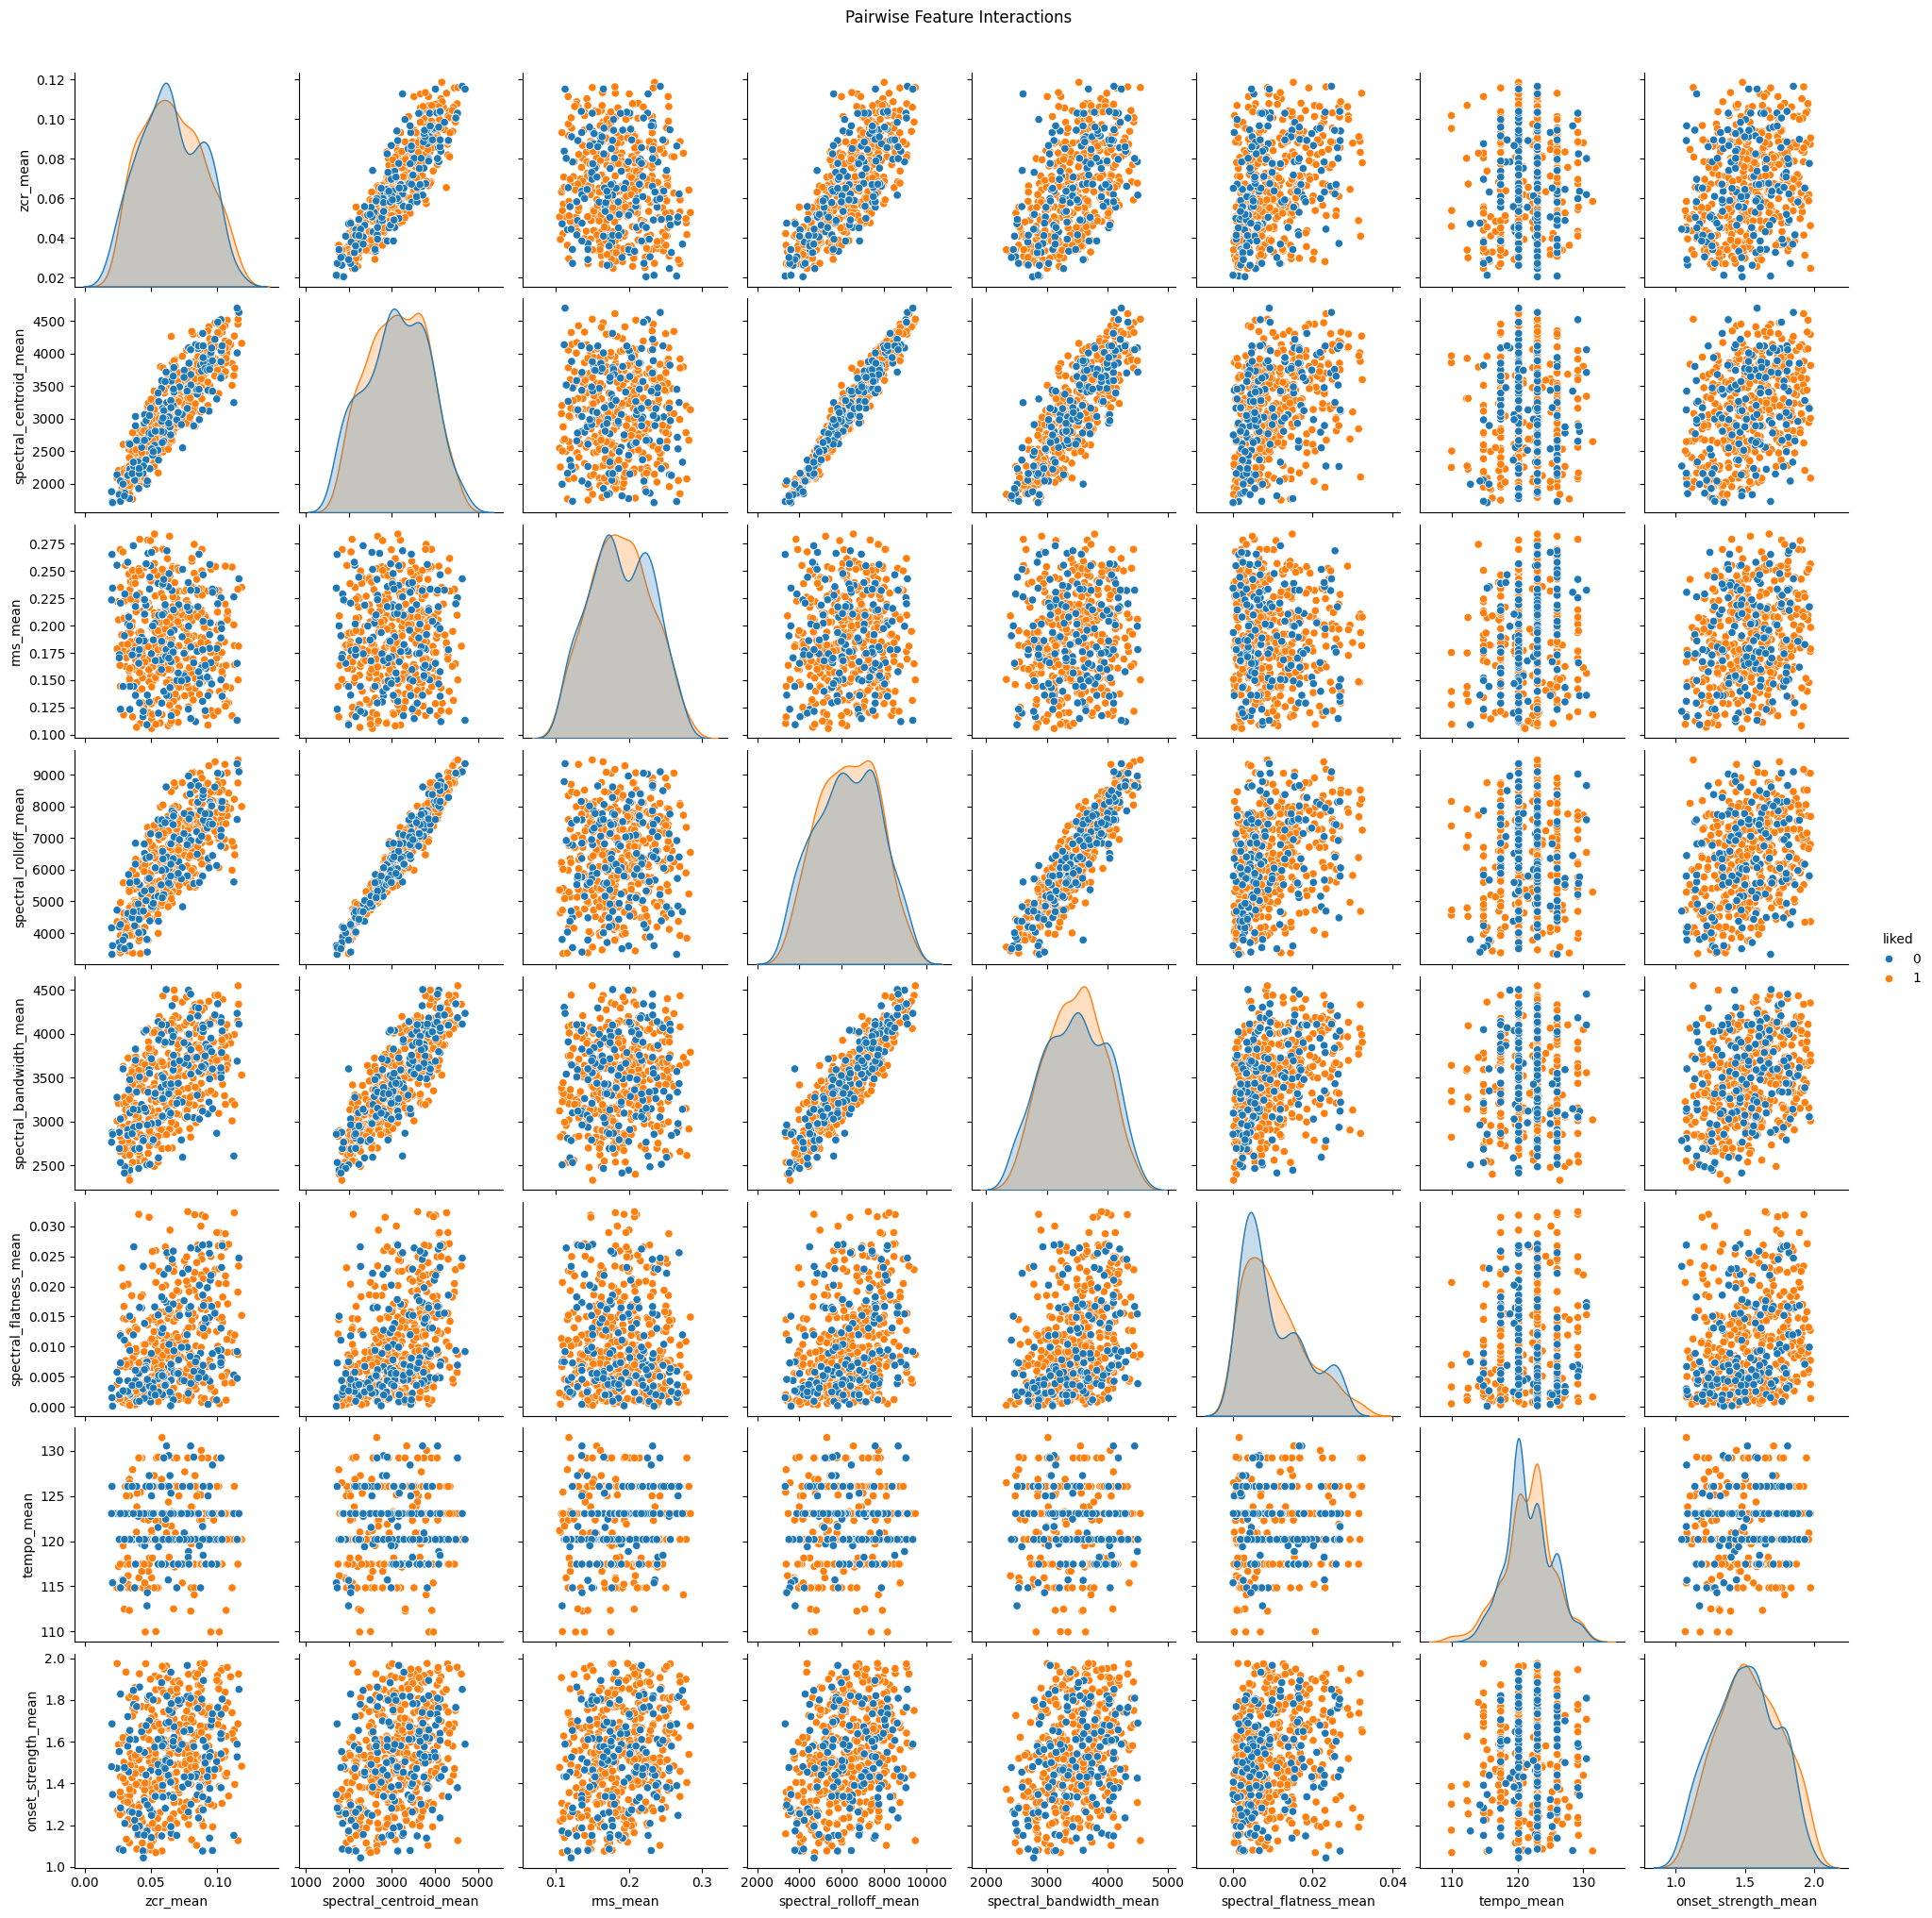

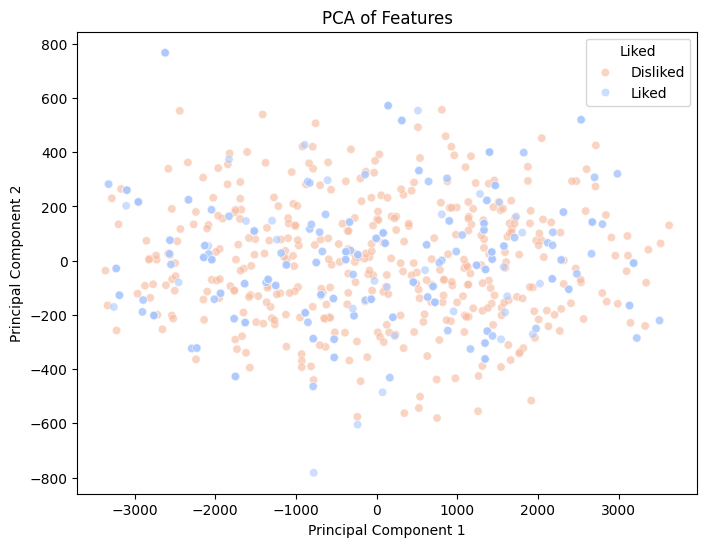

/Users/beenerdy/code/AI&ML/venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


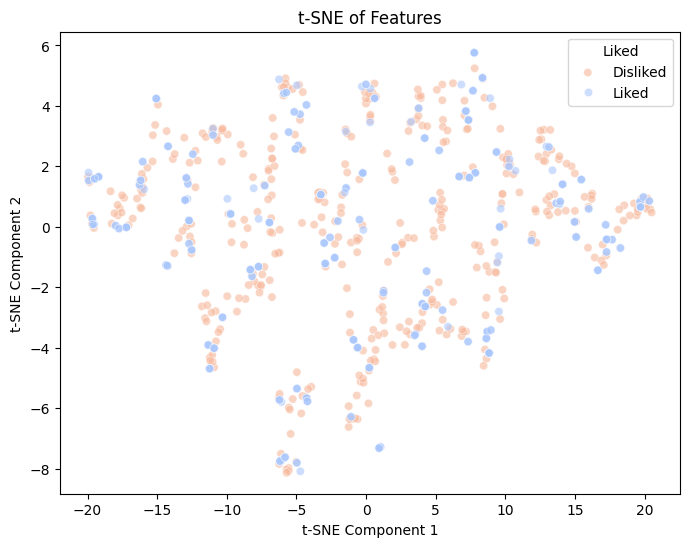

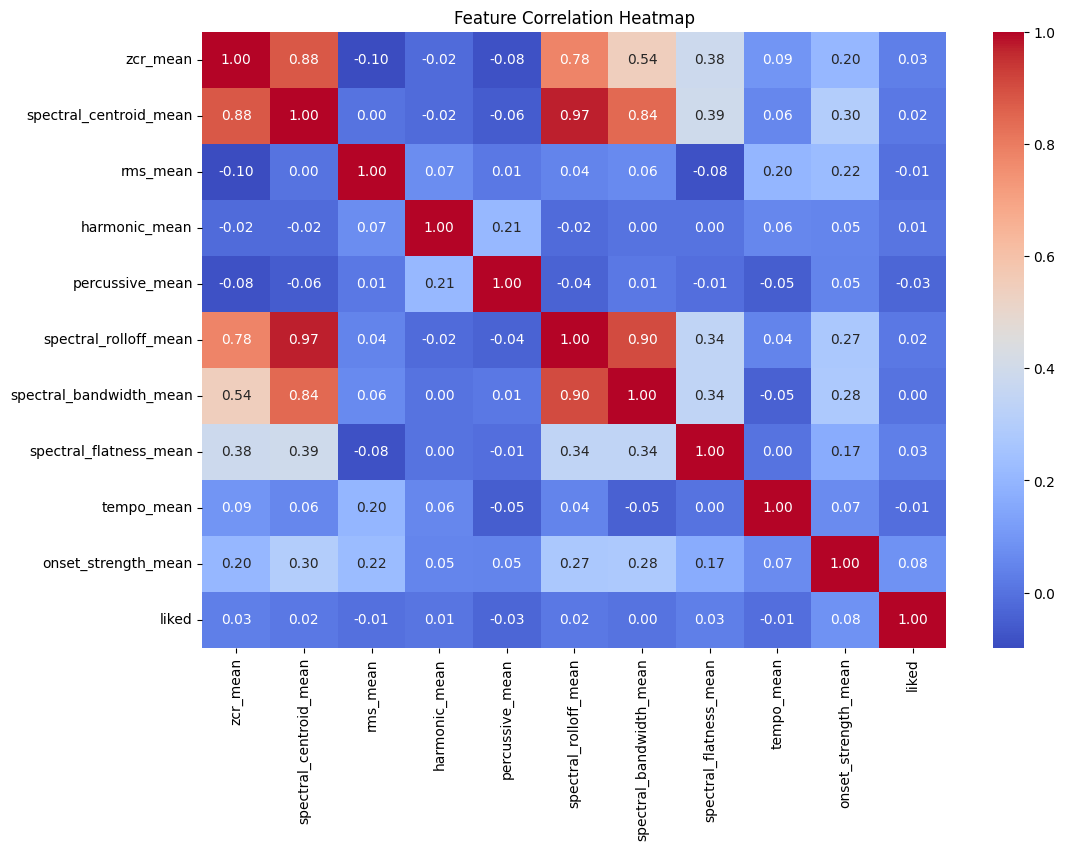

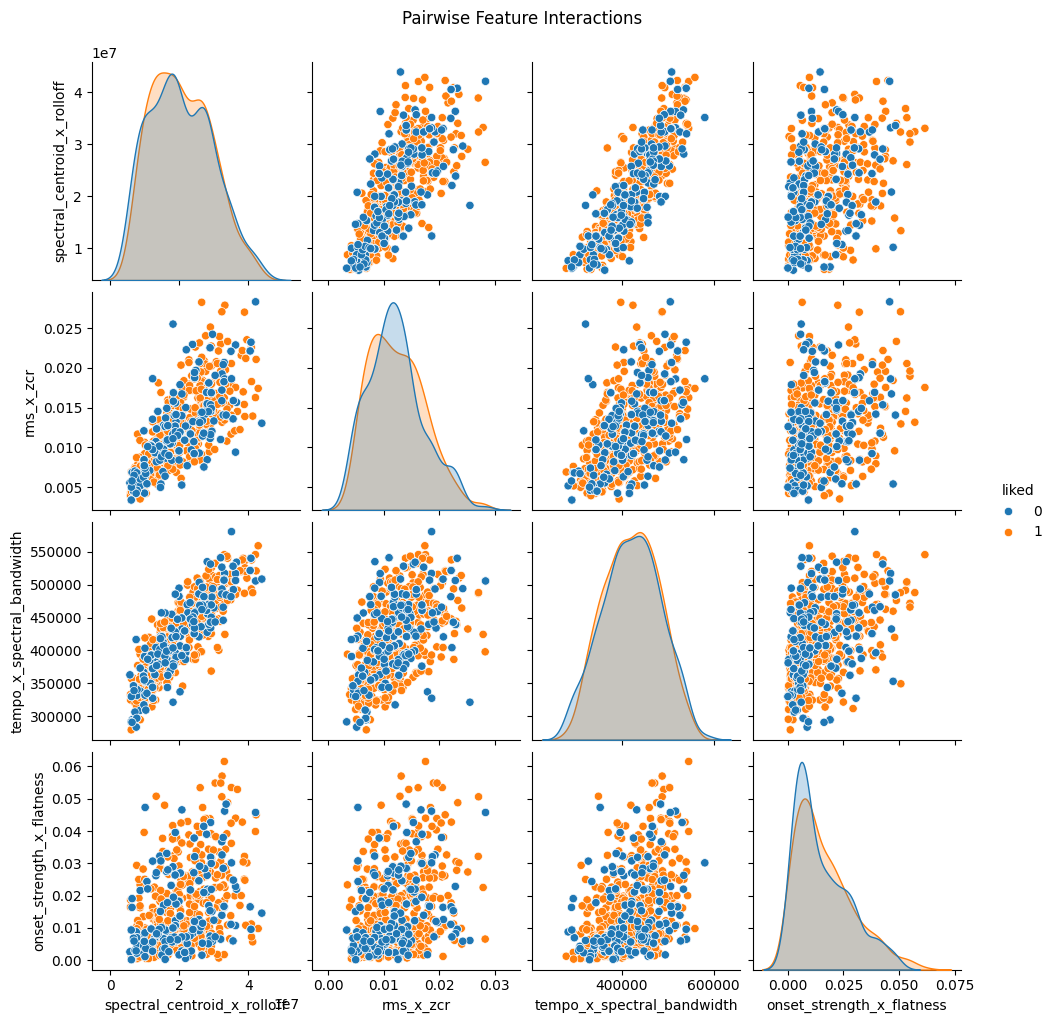

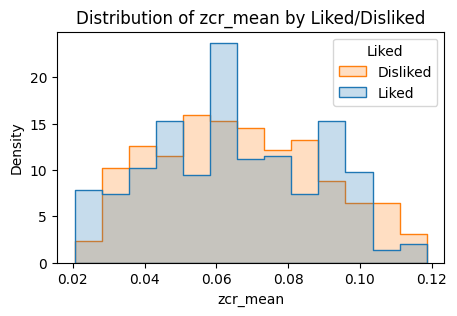

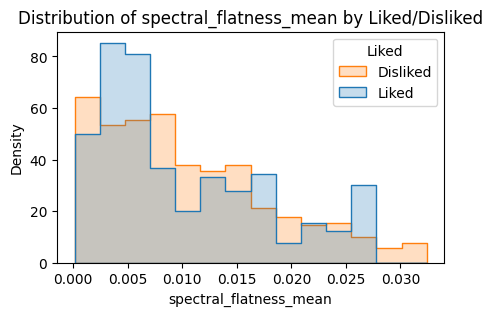

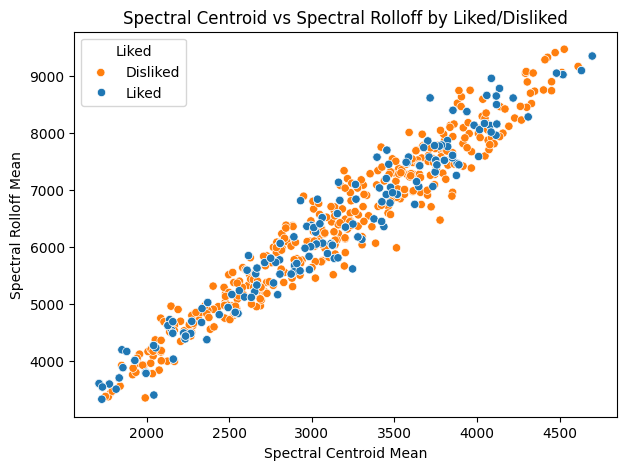

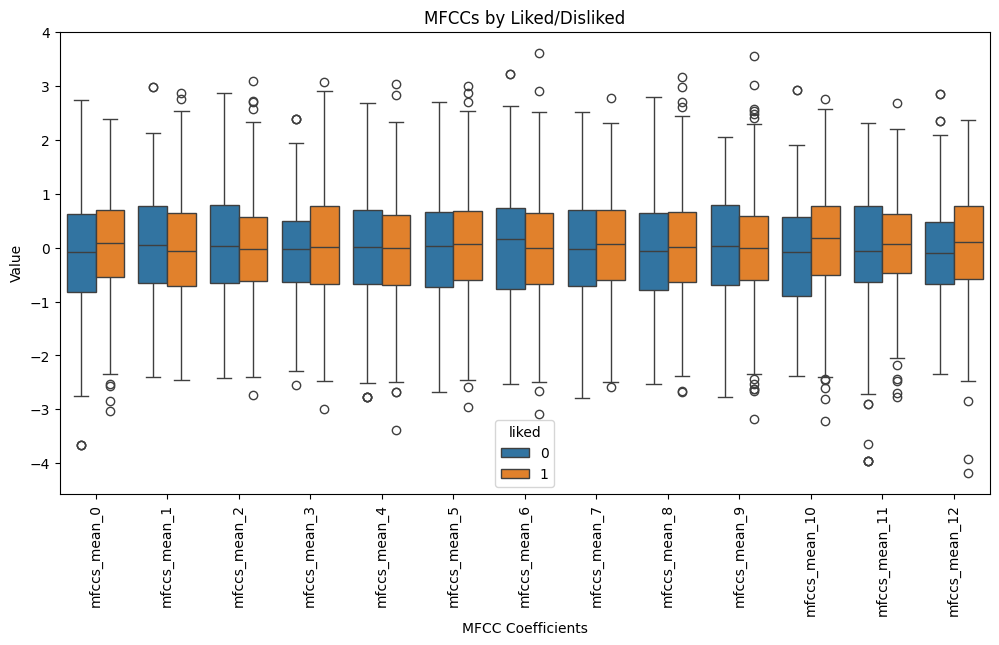

/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/950283846.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['liked'] = y_balanced_numeric


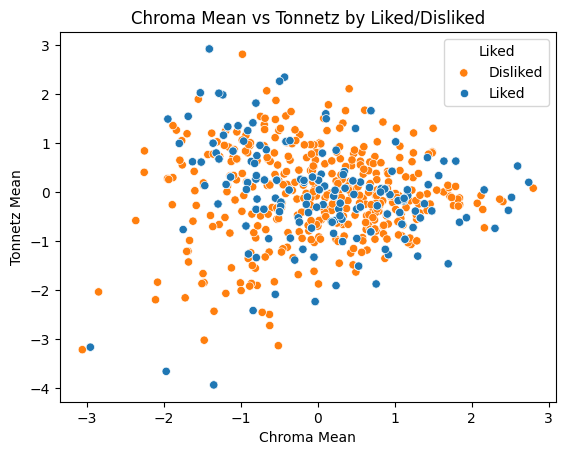

/var/folders/zs/dzp3881s2k95l_6q1w4m8y7c0000gp/T/ipykernel_17818/950283846.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['liked'] = y_balanced_numeric


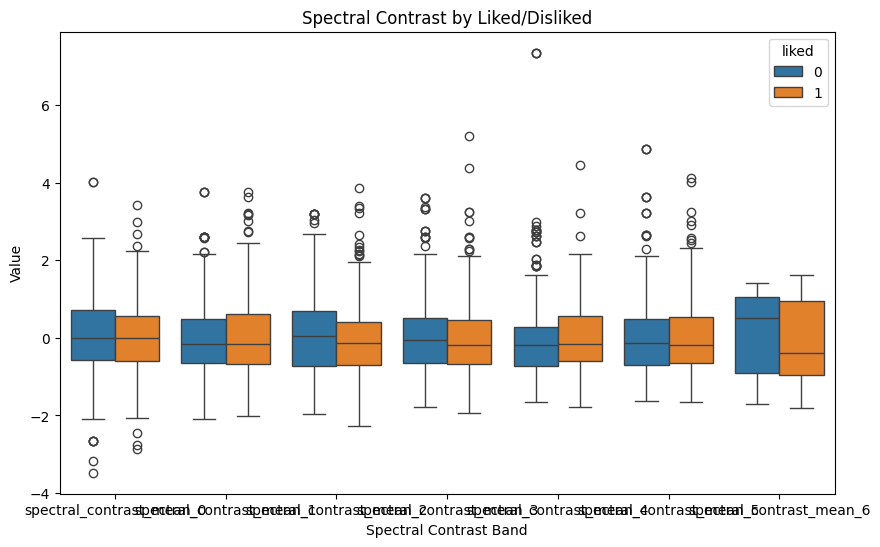

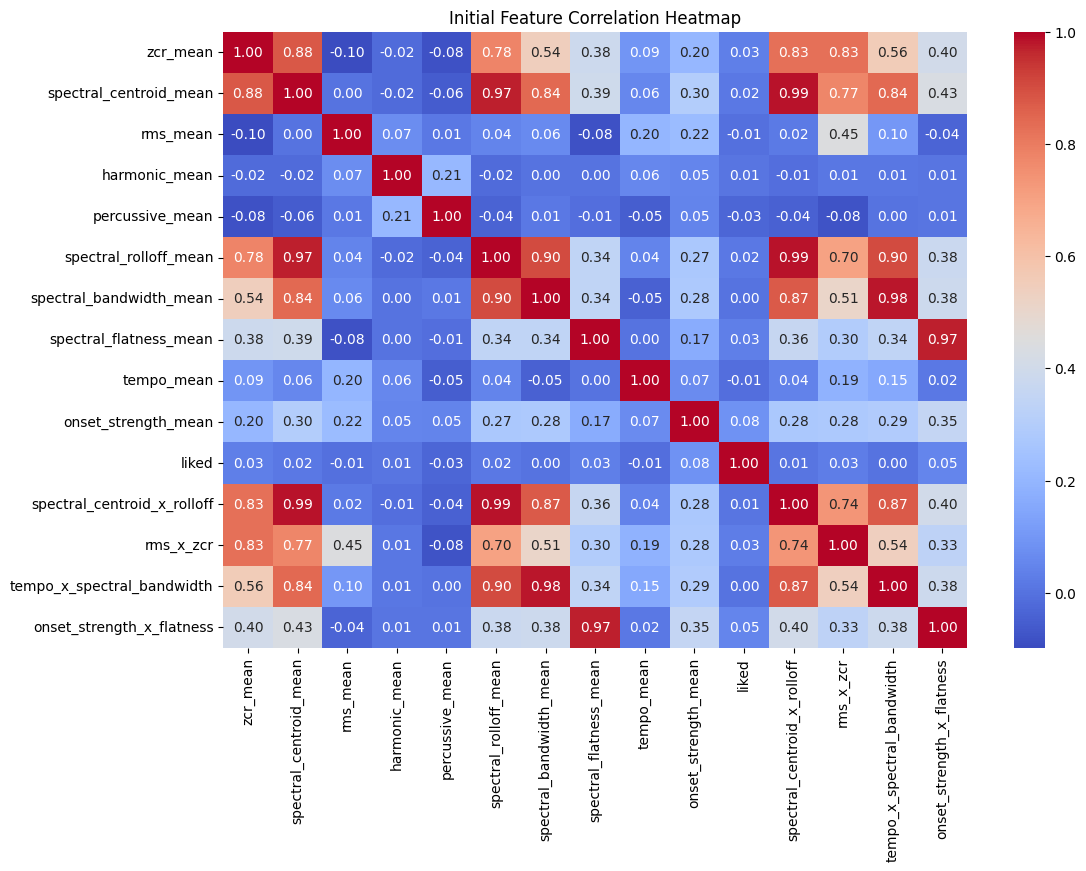

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assume X_static_df, X_time_series_df_scaled, y_balanced_numeric are already defined

# Plot pairwise interactions of selected static features
def plot_pairwise_interactions(features):
    sns.pairplot(X_static_df[features + ['liked']], hue='liked', diag_kind='kde')
    plt.suptitle('Pairwise Feature Interactions', y=1.02)
    plt.show()

# List of static features to analyze
static_features = ['zcr_mean', 'spectral_centroid_mean', 'rms_mean', 'spectral_rolloff_mean', 
                   'spectral_bandwidth_mean', 'spectral_flatness_mean', 'tempo_mean', 'onset_strength_mean']
plot_pairwise_interactions(static_features)

# PCA visualization of combined features
def plot_pca(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.6)
    plt.title('PCA of Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

# Combine time-series and static features for PCA and t-SNE
combined_features = np.hstack([X_time_series_df_scaled, X_static_df.drop('liked', axis=1)])
plot_pca(combined_features, y_balanced_numeric)

# t-SNE visualization of combined features
def plot_tsne(X, y, perplexity=30, n_iter=300):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm', alpha=0.6)
    plt.title('t-SNE of Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_tsne(combined_features, y_balanced_numeric)

# Correlation heatmap of static features
def plot_correlation_heatmap(df, title='Feature Correlation Heatmap'):
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_correlation_heatmap(X_static_df)

# Feature engineering: interaction terms
X_static_df['spectral_centroid_x_rolloff'] = X_static_df['spectral_centroid_mean'] * X_static_df['spectral_rolloff_mean']
X_static_df['rms_x_zcr'] = X_static_df['rms_mean'] * X_static_df['zcr_mean']
X_static_df['tempo_x_spectral_bandwidth'] = X_static_df['tempo_mean'] * X_static_df['spectral_bandwidth_mean']
X_static_df['onset_strength_x_flatness'] = X_static_df['onset_strength_mean'] * X_static_df['spectral_flatness_mean']

# Pairwise interactions of engineered features
interaction_features = ['spectral_centroid_x_rolloff', 'rms_x_zcr', 'tempo_x_spectral_bandwidth', 'onset_strength_x_flatness']
plot_pairwise_interactions(interaction_features)

# Plot histogram for a static feature
def plot_static_histogram(feature_name):
    if feature_name in X_static_df.columns:
        plt.figure(figsize=(5, 3))
        sns.histplot(data=X_static_df, x=feature_name, hue='liked', element='step', stat='density', common_norm=False)
        plt.title(f'Distribution of {feature_name} by Liked/Disliked')
        plt.xlabel(feature_name)
        plt.ylabel('Density')
        plt.legend(title='Liked', labels=['Disliked', 'Liked'])
        plt.show()
    else:
        print(f"Feature '{feature_name}' not found in X_static_df.")

plot_static_histogram('zcr_mean')
plot_static_histogram('spectral_flatness_mean')

# Scatterplot of spectral centroid vs spectral rolloff
def plot_spectral_centroid_vs_rolloff():
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=X_static_df, x='spectral_centroid_mean', y='spectral_rolloff_mean', hue='liked')
    plt.title('Spectral Centroid vs Spectral Rolloff by Liked/Disliked')
    plt.xlabel('Spectral Centroid Mean')
    plt.ylabel('Spectral Rolloff Mean')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_spectral_centroid_vs_rolloff()

# Boxplot of MFCCs by liked/disliked
def plot_mfccs_boxplot():
    plt.figure(figsize=(12, 6))
    mfcc_cols = [f'mfccs_mean_{i}' for i in range(13)]
    data = pd.DataFrame(X_time_series_df_scaled.iloc[:, :len(mfcc_cols)])
    data['liked'] = y_balanced_numeric
    melted_data = pd.melt(data, id_vars='liked', var_name='MFCC Coefficients', value_name='Value')
    sns.boxplot(x='MFCC Coefficients', y='Value', hue='liked', data=melted_data)
    plt.title('MFCCs by Liked/Disliked')
    plt.xticks(rotation=90)
    plt.show()

plot_mfccs_boxplot()

# Scatterplot of Chroma Mean vs Tonnetz
def plot_chroma_vs_tonnetz():
    chroma_cols = [f'chroma_mean_{i}' for i in range(12)]
    tonnetz_cols = [f'tonnetz_mean_{i}' for i in range(6)]
    data = X_time_series_df_scaled[tonnetz_cols + chroma_cols]
    data['liked'] = y_balanced_numeric
    sns.scatterplot(data=data, x=chroma_cols[0], y=tonnetz_cols[0], hue='liked')
    plt.title('Chroma Mean vs Tonnetz by Liked/Disliked')
    plt.xlabel('Chroma Mean')
    plt.ylabel('Tonnetz Mean')
    plt.legend(title='Liked', labels=['Disliked', 'Liked'])
    plt.show()

plot_chroma_vs_tonnetz()

# Boxplot of Spectral Contrast by liked/disliked
def plot_spectral_contrast():
    plt.figure(figsize=(10, 6))
    spectral_contrast_cols = [f'spectral_contrast_mean_{i}' for i in range(7)]
    data = X_time_series_df_scaled[spectral_contrast_cols]
    data['liked'] = y_balanced_numeric
    melted_data = pd.melt(data, id_vars='liked', var_name='Spectral Contrast Band', value_name='Value')
    sns.boxplot(x='Spectral Contrast Band', y='Value', hue='liked', data=melted_data)
    plt.title('Spectral Contrast by Liked/Disliked')
    plt.show()

plot_spectral_contrast()

# Initial correlation heatmap of static features
corr_matrix = plot_correlation_heatmap(X_static_df, title='Initial Feature Correlation Heatmap')


In [65]:
def remove_highly_correlated_features(X_balanced, y_balanced, threshold=0.9):
    combined_data = []
    
    # Prepare data with only key: scalar (numerical) pairs
    for data in X_balanced:
        key = list(data.keys())[0]
        scalar_data = {k: v for k, v in data[key].items() if np.isscalar(v)}  # Extract only scalar (numeric) data
        df = pd.DataFrame([scalar_data])
        if not df.empty:
            combined_data.append(df)
    
    if not combined_data:
        raise ValueError("No scalar data available after filtering. Please check your input data.")

    combined_df = pd.concat(combined_data, ignore_index=True)

    # Ensure we're only working with numeric columns
    numeric_df = combined_df.select_dtypes(include=[np.number])

    corr_matrix = numeric_df.corr().abs()
    print(f"Correlation matrix:\n{corr_matrix}")
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Columns to drop due to high correlation: {to_drop}")

    X_balanced_new = []
    for data in X_balanced:
        key = list(data.keys())[0]
        features = data[key]
        
        # Retain all original features, but drop highly correlated scalar ones
        reduced_data = {k: v for k, v in features.items() if k not in to_drop}
        reduced_data_dict = {key: reduced_data}
        X_balanced_new.append(reduced_data_dict)

    return X_balanced_new, y_balanced

In [66]:
X_balanced_new, y_balanced_new = remove_highly_correlated_features(X_balanced, y_balanced, threshold=0.9)

Correlation matrix:
                         zcr_mean  spectral_centroid_mean  rms_mean  \
zcr_mean                 1.000000                0.879814  0.097993   
spectral_centroid_mean   0.879814                1.000000  0.004062   
rms_mean                 0.097993                0.004062  1.000000   
harmonic_mean            0.016577                0.018605  0.073308   
percussive_mean          0.081847                0.058697  0.013739   
spectral_rolloff_mean    0.778645                0.973383  0.044424   
spectral_bandwidth_mean  0.543332                0.841802  0.062682   
spectral_flatness_mean   0.383008                0.393424  0.081116   
tempo_mean               0.091601                0.055396  0.201695   
onset_strength_mean      0.203649                0.298995  0.220181   

                         harmonic_mean  percussive_mean  \
zcr_mean                      0.016577         0.081847   
spectral_centroid_mean        0.018605         0.058697   
rms_mean             

In [67]:
X_time_series = []
X_static = []
labels = []  # List of labels, matching the structure of `y`

for feature_dict in X_balanced_new:
    for file_hash, features in feature_dict.items():
        time_series_features, static_features = separate_and_process_features({file_hash: features})
        X_time_series.append(time_series_features)
        X_static.append(static_features)
        # Find the corresponding label using the file_hash in `y`
        label = next((label_dict[file_hash] for label_dict in y_balanced_new if file_hash in label_dict), None)
        labels.append(label)

## Train the Model

In [68]:

# Convert lists to numpy arrays
X_time_series = np.array(X_time_series)
X_static = np.array(X_static)
labels = np.array(labels)

In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
import numpy as np

# Function for cross-validation
def cross_validate_model(model_func, X_time_series, X_static, y, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_roc_aucs = []

    for train_index, val_index in kfold.split(X_time_series):
        X_ts_train, X_ts_val = X_time_series[train_index], X_time_series[val_index]
        X_static_train, X_static_val = X_static[train_index], X_static[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Get model from model_func
        model = model_func()

        # Early stopping callback to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        model.fit(
            [X_ts_train, X_static_train], y_train,
            epochs=100, batch_size=32,
            validation_data=([X_ts_val, X_static_val], y_val),
            callbacks=[early_stopping],
            verbose=0  # Suppress output for readability
        )

        # Evaluate the model
        preds = model.predict([X_ts_val, X_static_val])
        preds_binary = (preds > 0.5).astype(int)
        accuracy = accuracy_score(y_val, preds_binary)
        roc_auc = roc_auc_score(y_val, preds)

        fold_accuracies.append(accuracy)
        fold_roc_aucs.append(roc_auc)

    return np.mean(fold_accuracies), np.mean(fold_roc_aucs)

In [70]:
num_segments = 4
features_per_segment = X_time_series.shape[1] // num_segments

# Adjust features_per_segment to use 9 features per segment
X_time_series_truncated = X_time_series[:, :num_segments * features_per_segment]  # Truncate to 36 features
X_time_series_reshaped = X_time_series_truncated.reshape((X_time_series.shape[0], num_segments, features_per_segment))

print("Reshaped X_time_series:", X_time_series_reshaped.shape)


Reshaped X_time_series: (782, 4, 9)


In [71]:

print(f"Length of X_time_series_reshaped: {len(X_time_series_reshaped)}")
print(f"Length of X_static: {len(X_static)}")


Length of X_time_series_reshaped: 782
Length of X_static: 782


In [72]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Train-test split
X_ts_train, X_ts_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_time_series_reshaped, X_static, labels, test_size=0.2, random_state=42
)

# Define the shapes for input
time_series_shape = (X_time_series_reshaped.shape[1], X_time_series_reshaped.shape[2])
static_shape = (X_static.shape[1],)

import numpy as np

# Ensure X_ts_train, X_static_train, X_ts_test, X_static_test are numpy arrays of type float32
X_ts_train = np.array(X_ts_train, dtype=np.float32)
X_ts_test = np.array(X_ts_test, dtype=np.float32)
X_static_train = np.array(X_static_train, dtype=np.float32)
X_static_test = np.array(X_static_test, dtype=np.float32)

# Check and convert y_train and y_test to numeric values if they are categorical strings
if y_train.dtype.kind in {'U', 'S'}:  # U and S indicate unicode and string types
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train).astype(np.float32)  # Convert to float32
    y_test = le.transform(y_test).astype(np.float32)  # Convert to float32


print(y_train[:3])



[0. 1. 1.]


In [73]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

from tensorflow.keras import layers, models, Input
import tensorflow as tf

def create_combined_model(time_series_shape, static_shape):
    # Time-Series Model
    time_series_input = Input(shape=time_series_shape, name='time_series_input')
    x = layers.Conv1D(filters=32, kernel_size=3, padding='same')(time_series_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=128, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Adding Residual Connection
    residual = layers.Conv1D(filters=128, kernel_size=1, padding='same')(time_series_input)
    x = layers.add([x, residual])
    x = layers.LeakyReLU()(x)
    
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.LayerNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    x = layers.LayerNormalization()(x)

    # Extended Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    attention = layers.LayerNormalization()(attention)
    x = layers.GlobalAveragePooling1D()(attention)

    time_series_output = layers.Dense(32, activation='relu')(x)

    # Static Features Model
    static_input = Input(shape=static_shape, name='static_input')
    y = layers.Dense(128)(static_input)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(64)(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(32)(y)
    static_output = layers.LeakyReLU()(y)

    # Combine Time-Series and Static Features
    combined = layers.concatenate([time_series_output, static_output])
    combined = layers.Dense(128)(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.LeakyReLU()(combined)
    combined = layers.Dropout(0.5)(combined)
    combined_output = layers.Dense(1, activation='sigmoid')(combined)

    model = models.Model(inputs=[time_series_input, static_input], outputs=combined_output)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay=1e-5), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model


In [74]:
print(X_ts_train[:1])
print(X_static_train[:1])
print(y_train[:1])

[[[-3.2762392   1.2537367   0.31114355  0.59181356  0.16704205
    0.35124516  0.21186002  0.17146353  0.02834764]
  [ 0.11155766  0.01117664  0.08901002 -0.02215738  1.
    0.73617023  0.4533374   0.3727825   0.5324116 ]
  [ 0.28453293  0.          0.15008989  0.32296464  0.51140857
    0.6142385   0.8232855   0.19488887  0.        ]
  [ 0.06348306  0.09052514  0.10191597  0.10901555  1.
    1.          0.06001042  0.          0.6039107 ]]]
[[3.85079756e-02 0.00000000e+00 1.96774602e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.23046875e+02 0.00000000e+00]]
[0.]


In [75]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Train and evaluate the model

# EarlyStopping with patience for complex data
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

combined_model = create_combined_model(time_series_shape, static_shape)

history = combined_model.fit(
    [X_ts_train, X_static_train], y_train,
    epochs=200, batch_size=32,
    validation_data=([X_ts_test, X_static_test], y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_preds = combined_model.predict([X_ts_test, X_static_test])

# Convert predictions to binary labels
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate accuracy and ROC AUC score
test_accuracy = accuracy_score(y_test, test_preds_binary)
test_roc_auc = roc_auc_score(y_test, test_preds)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')

# Convert predictions to percentage likelihoods
test_preds_percent = test_preds * 100

# Optionally print out some examples
for i in range(5):  # Show the first 5 predictions
    print(f"Song {i+1}: Predicted likelihood of liking: {test_preds_percent[i][0]:.2f}%")


Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5571 - loss: 0.8431 - val_accuracy: 0.4713 - val_loss: 6.7408
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5024 - loss: 0.9873 - val_accuracy: 0.4713 - val_loss: 5.9645
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4788 - loss: 1.0198 - val_accuracy: 0.4713 - val_loss: 5.2484
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5031 - loss: 0.8893 - val_accuracy: 0.4713 - val_loss: 4.4872
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5358 - loss: 0.8930 - val_accuracy: 0.4713 - val_loss: 3.8271
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5117 - loss: 0.9495 - val_accuracy: 0.4713 - val_loss: 3.2035
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5264 - loss: 0.8761 - val_accuracy: 0.4713 - val_loss: 2.6649
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5653 - loss: 0.8708 - val_accuracy: 0.4713 

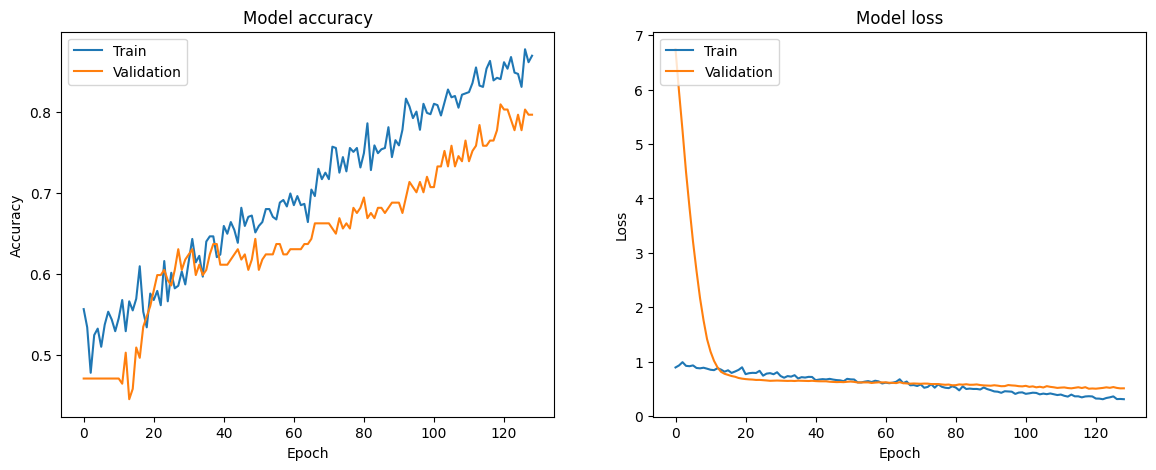

In [76]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [81]:
from keras.saving import save_model

# Save the model to an HDF5 file (or TensorFlow SavedModel format)
model_path = 'combined_model.h5'  # You can also specify a different path or file format
save_model(combined_model, model_path)
print(f"Model saved to {model_path}")

Model saved to combined_model.h5
